In [1]:
import polars as pl
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
### Train samples
train_sets = []
for i in range(5):
    train_sets.append(pl.read_csv(f"question_{i}_datamodels/train_set.csv").with_columns(pl.lit(f"question_{i}").alias("question_id")))
train = pl.concat(train_sets)

In [3]:
### Load weights
weights_set = []
for i in range(5):
    weights = torch.load(f"question_{i}_datamodels/models/regression_question_{i}/weights.pt").to("cpu")
    weights_set.append(weights)

/tmp/ipykernel_308240/3848620530.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"question_{i}_datamodels/models/regression_question_{i}/weights.pt

In [4]:

## add weights to sample training
list_weights = []
for set in weights_set:
    for _w in set[0]:
        list_weights.append(float(_w.item()))


train = train.with_columns(
    pl.Series("weights", list_weights),
    pl.when(pl.col("idx_right").is_not_null())
        .then(True)
        .otherwise(False)
        .alias("is_from_same_page")
)

In [5]:
questions = []
for i in range(5):
    questions.append(pl.read_csv(f"question_{i}_datamodels/test_set.csv"))

questions = pl.concat(questions)
questions.select("question").to_numpy()

array([['when did the who perform at the super bowl'],
       ['why was there so much interest in cuba both before and after the civil war'],
       ['who developed the first periodic table with 8 columns'],
       ['the organization of the formal elements in an art work'],
       ['where did the french king live before versailles']], dtype=object)

In [6]:
## Training collections
collections_training_set = []
for i in range(5):
    collection_i = pl.read_ipc(f"question_{i}_datamodels/collections/train/collection_question_{i}.feather").with_columns(pl.lit(f"question_{i}").alias("question_id"))
    collections_training_set.append(collection_i)


## Question 2

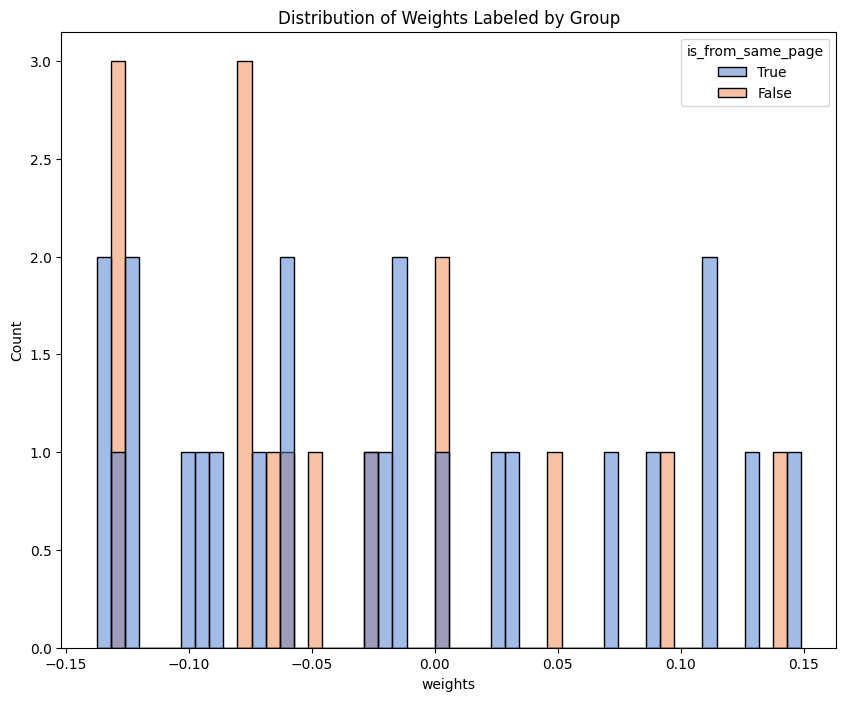

In [7]:
train_q2 = train.filter(pl.col("question_id") == "question_2")

distribution_q2 = (
    train_q2
    .select("weights", "is_from_same_page")
)
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(
    data=distribution_q2,
    x="weights",
    hue="is_from_same_page",
    bins=50,
    hue_order=[True, False],
    palette="muted",
    ax=ax
)

plt.title("Distribution of Weights Labeled by Group")
plt.show()

In [8]:
questions[2]

example_id,question,answers,text,idx_gold_in_corpus
i64,str,str,str,i64
1317425899790858647,"""who developed the first period…","""Dmitri Mendeleev""","""The Russian chemist Dmitri Men…",20970755


In [9]:
train_q2.filter(pl.col("weights") > 0).sort("weights")

idx,text,title,idx_right,question_id,weights,is_from_same_page
i64,str,str,i64,str,f64,bool
3,"""being completed if a result is…","""Limited overs cricket""",null,"""question_2""",0.000651,false
1,"""Antifascista (UMA)"". The ""Unió…","""Unión Militar Republicana Ant…",null,"""question_2""",0.0044,false
18,"""In 1914 , a year before he was…","""History of the periodic table""",20970755,"""question_2""",0.005688,true
8,"""the work of Dmitri Mendeleev h…","""History of the periodic table""",20970755,"""question_2""",0.027457,true
0,"""History of the periodic table …","""History of the periodic table""",20970755,"""question_2""",0.031232,true
…,…,…,…,…,…,…
21,"""A number of physical elements …","""History of the periodic table""",20970755,"""question_2""",0.112693,true
12,"""published his periodic table o…","""History of the periodic table""",20970755,"""question_2""",0.11425,true
11,"""in an obscure Russian journal …","""History of the periodic table""",20970755,"""question_2""",0.129696,true


In [10]:
train_q2.filter(pl.col("weights") > 0.1).sort("weights").select(["idx", "is_from_same_page", "text"]).to_numpy()

array([[21, True,
        'A number of physical elements ( such as platinum , tin and zinc ) have been known from antiquity , as they are found in their native form and are relatively simple to mine with primitive tools . Around 330 BCE , the Greek philosopher Aristotle proposed that everything is made up of a mixture of one or more roots , an idea that had originally been suggested by the Sicilian philosopher Empedocles . The four roots , which were later renamed as elements by Plato , were earth , water , air and fire . Similar ideas about these four elements also existed in other ancient traditions , such as Indian philosophy . While Aristotle and Plato understood the concept of an element , their ideas did nothing to advance the understanding of the nature of matter .'],
       [12, True,
        "published his periodic table of the known elements, predicted new elements to help complete his table and corrected the atomic weights of some of the elements, Meyer published a virtually

In [11]:
train_collections_q2 = collections_training_set[2].with_columns(pl.col("input").arr.to_struct(fields = lambda i: f"input_{i}")).unnest("input")
train_collections_q2.filter(pl.col("input_28") == 1).filter(pl.col("evaluation") > 0)

collection_idx,test_idx,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,input_14,input_15,input_16,input_17,input_18,input_19,input_20,input_21,input_22,input_23,input_24,input_25,input_26,input_27,input_28,input_29,input_30,input_31,input_32,input_33,input_34,input_35,input_36,input_37,input_38,evaluation,question_id
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,str
96,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1.0,"""question_2"""
101,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1.0,"""question_2"""
102,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0.666667,"""question_2"""
107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0.666667,"""question_2"""
113,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1.0,"""question_2"""


## Question 0

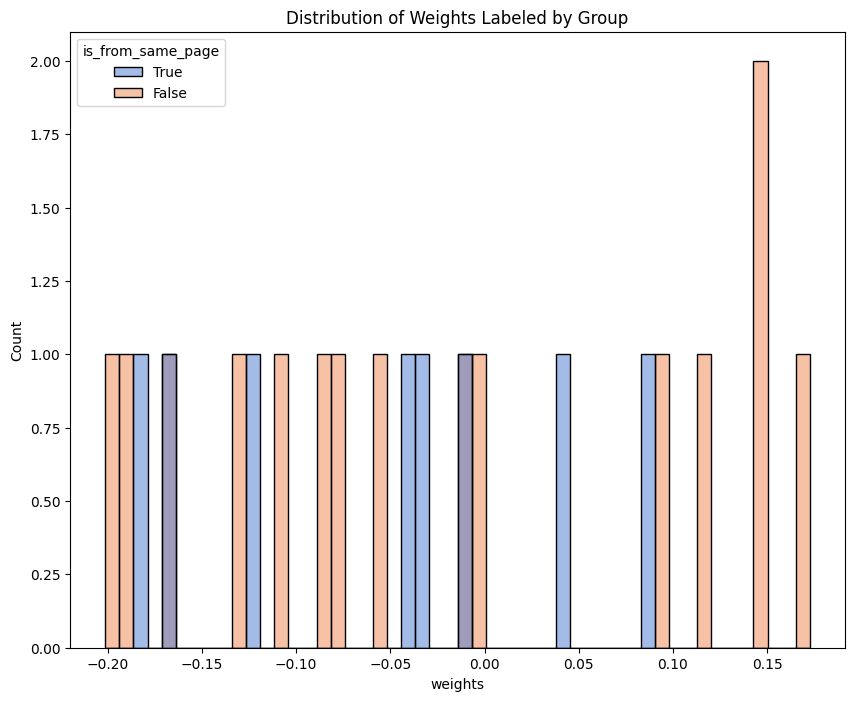

In [12]:
train_q0 = train.filter(pl.col("question_id") == "question_0")

distribution_q0 = (
    train_q0
    .select("weights", "is_from_same_page")
)
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(
    data=distribution_q0,
    x="weights",
    hue="is_from_same_page",
    bins=50,
    hue_order=[True, False],
    palette="muted",
    ax=ax
)

plt.title("Distribution of Weights Labeled by Group")
plt.show()

In [13]:
questions[0]

example_id,question,answers,text,idx_gold_in_corpus
i64,str,str,str,i64
4393532674001821363,"""when did the who perform at th…","""Feb 7 , 2010""","""XLIV Date : Feb 7 , 2010 Locat…",20970820


In [14]:
train_q0.filter(pl.col("weights") > 0).sort("weights")

idx,text,title,idx_right,question_id,weights,is_from_same_page
i64,str,str,i64,str,f64,bool
0,"""Cessna 421 The Cessna 421 Gold…","""Cessna 421""",null,"""question_0""",0.000608,false
0,"""Date : Feb 5 , 2017 Location :…","""List of Super Bowl halftime sh…",20970820,"""question_0""",0.041878,true
6,"""Halftime shows are a tradition…","""List of Super Bowl halftime sh…",20970820,"""question_0""",0.085063,true
8,"""Manassas Regional Airport Mana…","""Manassas Regional Airport""",null,"""question_0""",0.091514,false
4,"""Alonso composed over two thous…","""Tite Curet Alonso""",null,"""question_0""",0.117261,false
13,"""world"" of the camp and its sur…","""Psychonauts""",null,"""question_0""",0.144831,false
3,"""on the application of patients…","""Medical tourism""",null,"""question_0""",0.145593,false
14,"""He later went on to work as a …","""Bodo Illgner""",null,"""question_0""",0.172659,false


In [17]:
train_q0.filter(pl.col("weights") > 0.1).sort("weights").select(["idx", "is_from_same_page", "text"]).to_numpy()

array([[4, False,
        'Alonso composed over two thousand songs. Arguably, about 200 of these were hit songs, and about 50 of these were major salsa hits. Some of the people who have intrepeted his songs are: Joe Quijano, Iris Chacón, Wilkins, Cheo Feliciano, Celia Cruz, La Lupe, Willie Colón, Tito Rodríguez, Olga Guillot, Mon Rivera, Héctor Lavoe, Ray Barretto, Tony Croatto, Rubén Blades, Tito Puente, Ismael Miranda, Roberto Roena, Bobby Valentín, Marvin Santiago, Willie Rosario, Chucho Avellanet, Andy Montañez, Rafael Cortijo, Tommy Olivencia and Frankie Ruiz. His song "Las Caras Lindas (De Mi Gente Negra)" (The Beautiful Faces (Of My Black People) recorded'],
       [13, False,
        'world" of the camp and its surroundings, as well as a number of "mental worlds" which exist in the consciousness of the game\'s various characters. The mental worlds have wildly differing art and level design aesthetics, but generally have a specific goal that Raz must complete to help resolve a p

In [25]:
train_collections_q0 = collections_training_set[0].with_columns(pl.col("input").arr.to_struct(fields = lambda i: f"input_{i}")).unnest("input")
train_collections_q0.filter(pl.col("evaluation") > 0)

collection_idx,test_idx,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,input_14,input_15,input_16,input_17,input_18,input_19,input_20,input_21,input_22,evaluation,question_id
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,str
9,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.25,"""question_0"""
122,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0.222222,"""question_0"""
124,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.285714,"""question_0"""
